## Visualization

In [214]:
import branca.colormap as cm
import folium
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

from branca import colormap
from geopy.geocoders import Nominatim
from matplotlib.colors import ListedColormap
from shapely.ops import unary_union
from shapely import wkt
from tqdm import tqdm

plt.style.use("dark_background")
matplotlib.rcParams.update({'font.size': 14})

### Coloring Methods

In [215]:
def get_alpha_blend_cmap(cmap: str, alpha: float):
    cls = plt.get_cmap(cmap)(np.linspace(0, 1, 256))
    cls = (1-alpha) + alpha*cls
    return ListedColormap(cls)


def get_color_palette_from_cmap(cmap_label: str, cmap_width: int, range_width: int, reversed: bool):
    colors = []
    cmap = plt.get_cmap(cmap_label, cmap_width)

    color_range = range(cmap_width - 1, cmap_width -
                        range_width - 1, -1) if reversed else range(range_width)
    for i in color_range:
        colors.append(cmap(i))
    return colors


def get_plot_kws(scatter_kws: str, line_kws: str):
    return {'line_kws': {'color': line_kws}, 'scatter_kws': {'color': scatter_kws}}

### Methods

In [216]:
def get_polygons(geolocator: Nominatim, bounding: str, geopy_index: int):
    polygons = []
    substracts = []
    for location in bounding.replace("[", "").replace("]", "").split(","):
        if location.startswith("-"):
            geocodes = geolocator.geocode(location[1:] + ', QC', geometry='wkt', exactly_one=False)
            for geocode in geocodes:
                substracts.append(wkt.loads(geocode.raw['geotext']))
        else:
            geocode = geolocator.geocode(location + ', QC', geometry='wkt', exactly_one=False)[geopy_index]
            polygons.append(wkt.loads(geocode.raw['geotext']))

    return polygons, substracts  

In [217]:
def add_geometry(geomap: folium.Map, geolocator: Nominatim, bounding: str, popup: str, color: str, geopy_index: int):
    polygons, substracts = get_polygons(geolocator, bounding, geopy_index)
    geo_json = gpd.GeoSeries(unary_union(polygons).difference(unary_union(substracts))).simplify(tolerance=0.001).to_json()
    geo_j = folium.GeoJson(data=geo_json, style_function=lambda x: {'weight': 2, 'color': 'white', 'fillOpacity': 0.3, 'fillColor': color}, zoom_on_click=True)
    folium.Popup(popup).add_to(geo_j)
    geo_j.add_to(geomap)

In [218]:
def reorder_column(df: pd.DataFrame, column: str):
    first_cols = [column]
    last_cols = [col for col in df.columns if col not in first_cols]
    return df[first_cols+last_cols]

In [219]:
def group_column(df: pd.DataFrame, column: str):
    value_counts = df[column].value_counts()
    df = df.groupby(column).mean().astype(int).reset_index()
    df.insert(0, 'Nb of listings', '')
    df['Nb of listings'] = df[column].map(value_counts).astype(int)
    return reorder_column(df, column)

In [220]:
def first_digits(number):
    return str(number)[:3]

def add_price_ranges(df: pd.DataFrame, prices: list):
    conditions = [df['Price'] < prices[0]]
    labels = ["0-" + first_digits(prices[0]) + "k"]

    for i in range(len(prices) - 1):
        conditions.append((df['Price'] >= prices[i]) & (df['Price'] < prices[i+1]))
        labels.append(first_digits(prices[i]) + "k-" + first_digits(prices[i+1]) + "k")
    conditions.append(df['Price'] >= prices[-1])
    labels.append(">" + first_digits(prices[-1]) + "k")
    df['Price Range'] = np.select(conditions, labels, default=0)
    return df

In [221]:
def add_value_ranges(df: pd.DataFrame, column: str, values: list, unit: str):
    conditions = [df[column] < values[0]]
    labels = ["0-" + str(values[0]) + " " + unit]

    for i in range(len(values) - 1):
        conditions.append((df[column] >= values[i]) & (df[column] < values[i+1]))
        labels.append(str(values[i]) + "-" + str(values[i+1]) + " "  + unit)
    conditions.append(df[column] >= values[-1])
    labels.append(">" + str(values[-1]) + " " + unit)
    df[column + ' Range'] = np.select(conditions, labels, default=0)
    return df

### Read Processed Data

In [222]:
listings_df = pd.read_csv('../data/processed/processed_listings.csv')
listings_df = add_price_ranges(listings_df, [200000, 250000, 300000, 350000, 400000, 450000, 500000, 600000])
listings_df = add_value_ranges(listings_df, "Living Area", [1000, 1250, 1500, 2000], "sq.ft")
listings_df.sample(5)

,Subtype,Style,Living Area,Lot Dimensions,Bedrooms,Bathrooms,Levels,Listing Date,Listing Year,Year of Construction,Location,RCM,Region,Price,Price Range,Living Area Range
46082,Condominium,Unknown,568,9084,1,1,1,2013-08-01,2013,2005,Gatineau,Gatineau,Outaouais,126500,0-200k,0-1000 sq.ft
117517,Townhouse,Townhouse,1440,4000,2,1,2,2012-02-01,2012,2010,Sherbrooke,Sherbrooke,Estrie,190000,0-200k,1250-1500 sq.ft
111328,Condominium,Divided Co-Ownership,600,961,1,1,1,2011-06-01,2011,1987,Sainte-Foy-Sillery-Cap-Rouge,Québec,Capitale-Nationale,122500,0-200k,0-1000 sq.ft
93876,Condominium,Unknown,959,9084,2,1,1,2018-03-01,2018,1994,Saint-Bruno-de-Montarville,Longueuil,Montérégie,154000,0-200k,0-1000 sq.ft
53074,Bungalow,Unknown,860,10161,2,2,1,2019-05-01,2019,1990,Joliette,Joliette,Lanaudière,180000,0-200k,0-1000 sq.ft


### Correlation Map

In [223]:
def plot_corr_map(df):
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    _, _ = plt.subplots(figsize=(11, 9))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, vmax=.3, cmap=get_alpha_blend_cmap("rocket_r", 0.9), center=0,
                square=True, linewidths=0, cbar_kws={"shrink": .5})

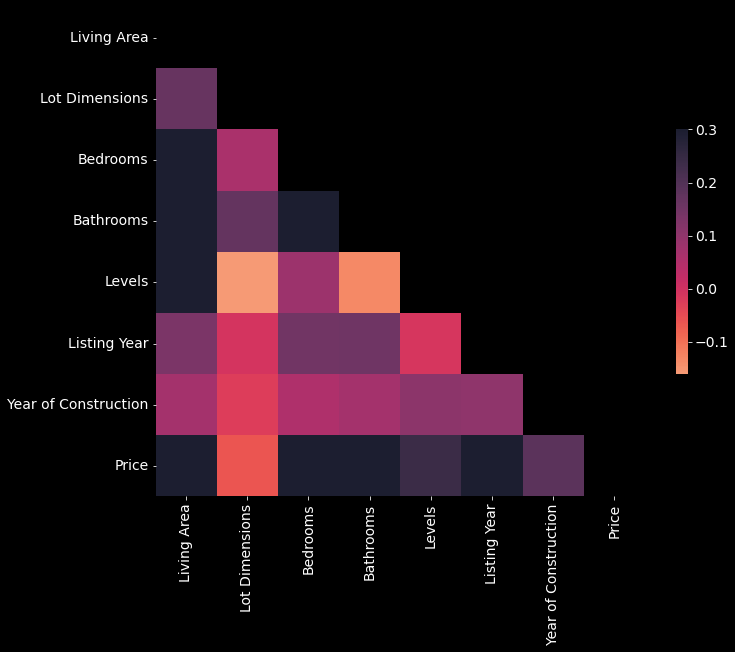

In [224]:
plot_corr_map(listings_df)

### Subtype

In [225]:
subtype_df = group_column(listings_df, 'Subtype')
subtype_df = subtype_df.sort_values(by=['Price'], ascending=True)
subtype_df.head()

,Subtype,Nb of listings,Living Area,Lot Dimensions,Bedrooms,Bathrooms,Levels,Listing Year,Year of Construction,Price
4,Condominium,18874,1057,8506,2,1,1,2015,1995,247237
0,1 1/2 Storey,2846,1452,13998,3,1,1,2016,1972,252673
5,Country Home,455,1514,17922,3,1,1,2015,1977,254970
3,Bungalow,36984,1143,10194,3,1,1,2016,1983,277502
7,Split Level,2889,1364,9122,3,1,1,2015,1986,311208


C:\Users\simka\AppData\Local\Temp\ipykernel_9348\946444578.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0", "100k", "200k", "300k", "400k", "500k"])


<AxesSubplot:title={'center':'Average Selling Price per Subtype'}, xlabel='Subtype', ylabel='Price ($)'>

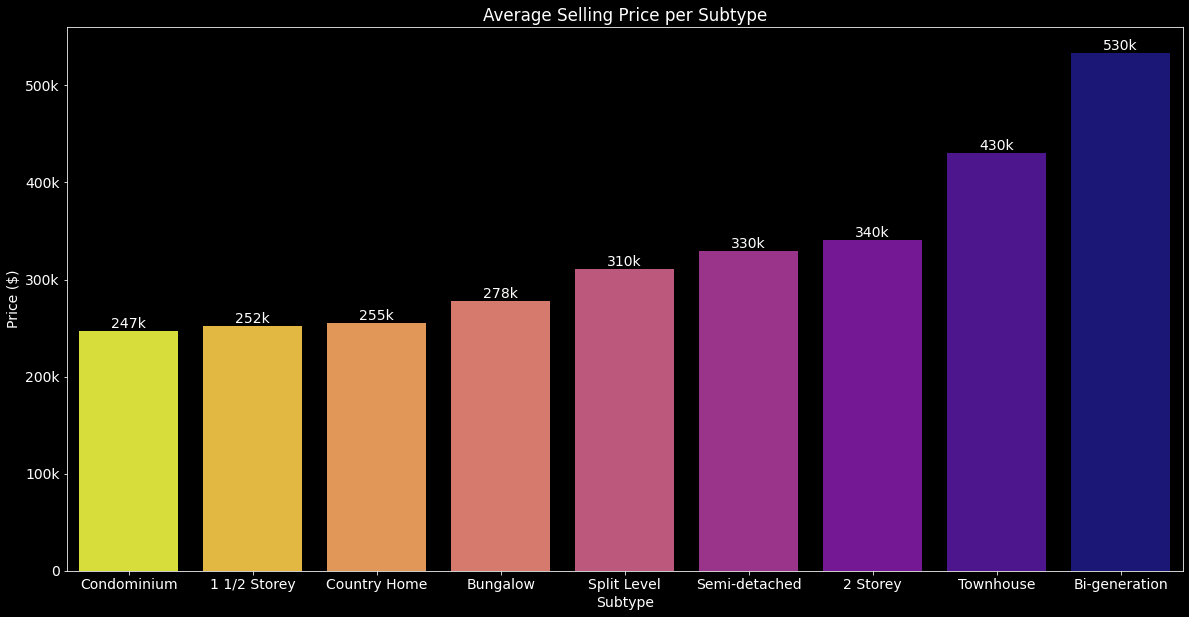

In [226]:
fig = plt.figure(figsize=[20, 10])
ax = sns.barplot(x="Subtype", y="Price", data=subtype_df, palette=get_color_palette_from_cmap("plasma", 9, 9, True))

ax.set_title("Average Selling Price per Subtype")
ax.set_ylabel("Price ($)")
ax.set_yticklabels(["0", "100k", "200k", "300k", "400k", "500k"])
ax.bar_label(ax.containers[0], labels=["247k", "252k", "255k", "278k", "310k", "330k", "340k", "430k", "530k"])
fig.add_axes(ax)

### Living Area

In [227]:
la_df = group_column(listings_df, 'Living Area Range')
la_df = la_df.sort_values(by=['Price'], ascending=True)
la_df.head()

,Living Area Range,Nb of listings,Living Area,Lot Dimensions,Bedrooms,Bathrooms,Levels,Listing Year,Year of Construction,Price
0,0-1000 sq.ft,28243,865,7561,2,1,1,2016,1992,246083
1,1000-1250 sq.ft,33683,1125,8117,3,1,1,2016,1991,261220
2,1250-1500 sq.ft,24158,1328,9197,3,1,1,2017,1984,328272
3,1500-2000 sq.ft,25684,1680,9068,3,1,2,2017,1996,414163
4,>2000 sq.ft,14482,2307,11985,3,2,1,2018,1997,432138


C:\Users\simka\AppData\Local\Temp\ipykernel_9348\2809449439.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0", "100k", "200k", "300k", "400k"])


<AxesSubplot:title={'center':'Average Selling Price per Living Area Range'}, xlabel='Living Area Range', ylabel='Price ($)'>

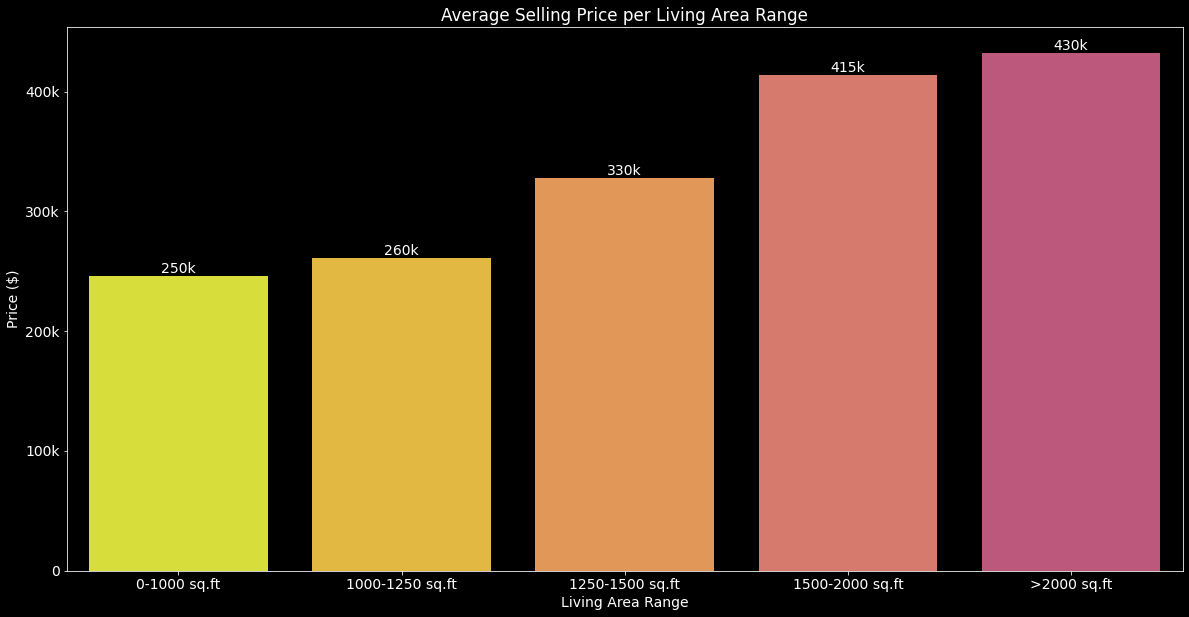

In [228]:
fig = plt.figure(figsize=[20, 10])
ax = sns.barplot(x="Living Area Range", y="Price", data=la_df, palette=get_color_palette_from_cmap("plasma", 9, 9, True))

ax.set_title("Average Selling Price per Living Area Range")
ax.set_ylabel("Price ($)")
ax.set_yticklabels(["0", "100k", "200k", "300k", "400k"])
ax.bar_label(ax.containers[0], labels=["250k", "260k", "330k", "415k", "430k"])
fig.add_axes(ax)

C:\Users\simka\AppData\Local\Temp\ipykernel_9348\3262273014.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0", "200k", "400k", "600k", "800k", "1M"])


[Text(0, -200000.0, '0'),
 Text(0, 0.0, '200k'),
 Text(0, 200000.0, '400k'),
 Text(0, 400000.0, '600k'),
 Text(0, 600000.0, '800k'),
 Text(0, 800000.0, '1M'),
 Text(0, 1000000.0, ''),
 Text(0, 1200000.0, '')]

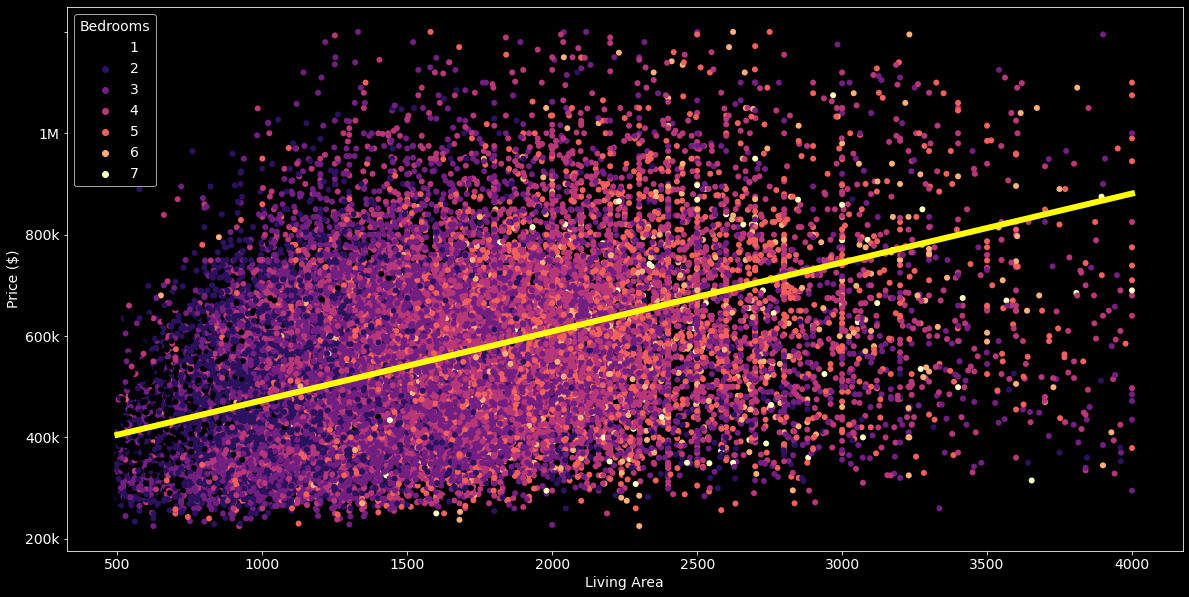

In [179]:
fig, ax = plt.subplots(figsize=(20, 10))
p1 = sns.scatterplot(data=listings_df, x="Living Area", y="Price", hue="Bedrooms", palette="magma", linewidth=0, ax=ax)
p2 = sns.regplot(data=listings_df, x='Living Area', y='Price', color='yellow', line_kws={'linewidth':6}, ax=ax, scatter=False)

ax.set_ylabel("Price ($)")
ax.set_yticklabels(["0", "200k", "400k", "600k", "800k", "1M"])

### Lot Dimensions

C:\Users\simka\AppData\Local\Temp\ipykernel_9348\4185090069.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0", "200k", "400k", "600k", "800k", "1M"])


[Text(0, -200000.0, '0'),
 Text(0, 0.0, '200k'),
 Text(0, 200000.0, '400k'),
 Text(0, 400000.0, '600k'),
 Text(0, 600000.0, '800k'),
 Text(0, 800000.0, '1M'),
 Text(0, 1000000.0, ''),
 Text(0, 1200000.0, '')]

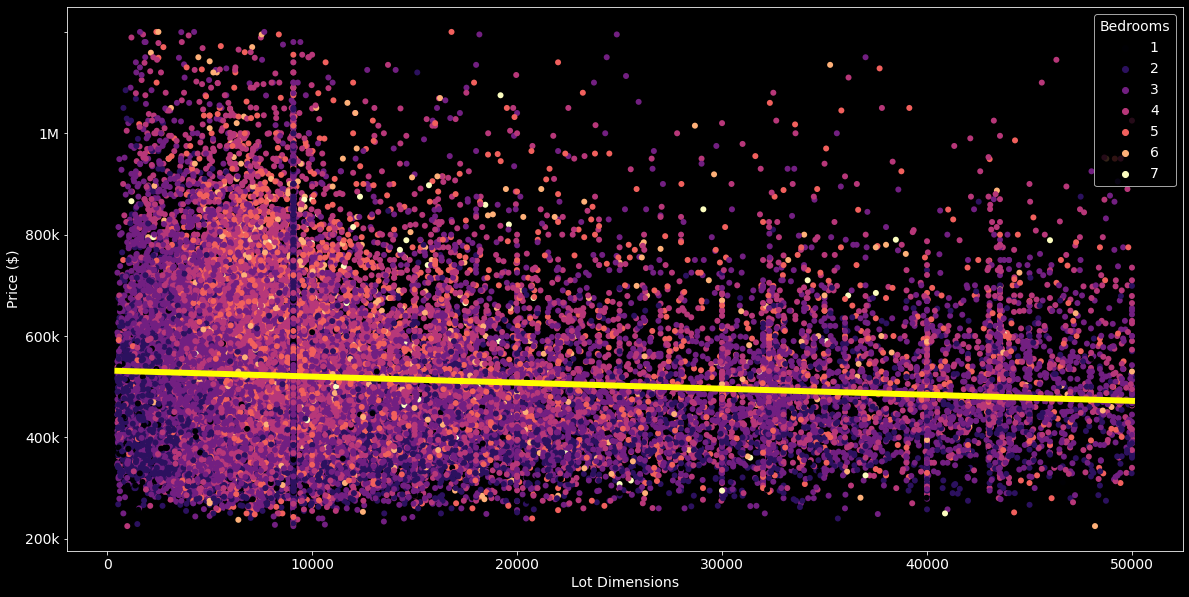

In [180]:
fig, ax = plt.subplots(figsize=(20, 10))
p1 = sns.scatterplot(data=listings_df, x="Lot Dimensions", y="Price", hue="Bedrooms", palette="magma", linewidth=0, ax=ax)
p2 = sns.regplot(data=listings_df, x='Lot Dimensions', y='Price', color='yellow', line_kws={'linewidth':6}, ax=ax, scatter=False)

ax.set_ylabel("Price ($)")
ax.set_yticklabels(["0", "200k", "400k", "600k", "800k", "1M"])

### Bedrooms

### Bathrooms

### Levels

### Listing Year

### Year of Construction

### Location

Read Data

In [142]:
locations_df = pd.read_csv('../data/processed/visualization/locations.csv')
locations_df.head()

,Location,Region,Bounding Territory,Population,GeoPy Index,Nb of listings,Subtype,Living Area,Lot Dimensions,Bedrooms,Bathrooms,Levels,Listing Year,Year of Construction,Price,Price Range
0,Bas-Saint-Laurent,Bas-Saint-Laurent,Bas-Saint-Laurent,200000,0,1054,Bungalow,1266,11372,3,1,1,2016,1984,207908,0-210k
1,Gaspésie-Îles-de-la-Madeleine,Gaspésie-Îles-de-la-Madeleine,Gaspésie-Îles-de-la-Madeleine,90000,0,248,Bungalow,1329,19161,3,1,1,2016,1976,181463,0-210k
2,La Cité-Limoilou,Capitale-Nationale,La Cité-Limoilou,100000,0,836,Condominium,1194,6547,2,1,1,2015,1967,285582,275k-300k
3,Les Rivières,Capitale-Nationale,Les Rivières,75000,0,2458,Condominium,1164,6353,2,1,1,2014,1995,255670,250k-275k
4,Sainte-Foy-Sillery-Cap-Rouge,Capitale-Nationale,Sainte-Foy-Sillery-Cap-Rouge,100000,0,2416,Bungalow,1252,7188,3,1,1,2014,1985,271915,250k-275k


Chlorpleth Map

In [143]:
geolocator = Nominatim(user_agent='housing-qc-viz')
qc_chloro_map = folium.Map(location=[47.0, -70.5], zoom_start=7)
folium.TileLayer('cartodbdark_matter').add_to(qc_chloro_map)  # Sets Tile Theme to (Dark Theme)

In [144]:
den_colormap = cm.linear.RdYlGn_11.colors
den_colormap.reverse()
colormap = cm.LinearColormap(colors=['darkgreen', 'green', 'limegreen', 'greenyellow', 'yellow', 'gold', 'orange', 'darkorange', 'red', 'darkred'], index=[
                             180000, 200000, 220000, 250000, 300000, 325000, 350000, 400000, 500000, 600000], vmin=180000, vmax=600000, max_labels=4)
                             
colormap.caption = 'Price'
colormap.add_to(qc_chloro_map)


In [145]:
for i, r in tqdm(locations_df.iterrows(), desc="Adding Geometries", total=locations_df.shape[0]):
    price = str(r["Price"])
    popup = r["Location"] + " - " + price[:3] + "k "+ "$"
    try:
        add_geometry(qc_chloro_map, geolocator, r["Bounding Territory"], popup, colormap(r["Price"]), r["GeoPy Index"])
    except:
        print("Unable to calculate geometry for: " + r["Bounding Territory"])

Adding Geometries: 100%|██████████| 110/110 [01:11<00:00,  1.54it/s]


In [146]:
qc_chloro_map